## Walmart Recruiting: Trip Type Classification

### Objective: 

- Trip Type Classification of each customers based on thier shopping data


### Data Description: 

- train : 647054 rows, 7 columns
- test : 653646 rows, 6 columns

| Index | Feature               | Feature Description                                  | Unique Value |
|-------|-----------------------|----------------------------------------------|--------|
| 1     | TripType              | A categorical id representing the type of shopping trip the customer made.                                       | 38     |
| 2     | VisitNumber           | An id corresponding to a single trip by a single customer                              | 95674  |
| 3     | Weekday               | The weekday of the trip                    | 7      |
| 4     | Upc                   | The UPC number of the product purchased                  | 97715  |
| 5     | ScanCount             | The number of the given item that was purchased. A negative value indicates a product return          | 39     |
| 6     | DepartmentDescription | A high-level description of the item's department                                | 69     |
| 7     | FinelineNumber        | A more refined category for each of the products, created by Walmart | 5196   |

### UPC code description
<img src="https://github.com/novdov/dss7_SWYA_walmart/blob/master/main/data/upc.png?raw=true", width="550">

### Evaluation : Multi-class log loss (Cross Entropy)
 $$-\frac{1}{N}\sum_{i=1}^N\sum_{j=1}^My_{ij}\log(p_{ij})$$

- $N$ : the number of visits in the test set
- $M$ : the number of trip types
- $\log$ : natural logarithm
- $y_{ij}$ : 1 if observation i is of class j and 0 otherwise
- $p_{ij}$ : the predicted probability that observation i belongs to class j

## Contents

- **[1. EDA & Preprocessing](#1.-EDA-&-Preprocessing)**  
<br>

- **[2. Feature Engineering](#2.-Feature-Engineering)**
    - UPC decoding
    - ScanCount seperation
    - Feature encoding
    - Dummy variables
    - Identifing the most frequently purchased items per VisitNumber

<br>
- **[3. Modeling](#3.-Modeling)**
    - XGBoost


# 1. EDA & Preprocessing

In [46]:
import numpy as np
import pandas as pd
from collections import Counter

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%config InlineBackend.figure_formats = {'png', 'retina'}

In [47]:
train = pd.read_csv("../input/walmart/train.csv")
test = pd.read_csv("../input/walmart/test.csv")

In [48]:
print(train.shape)
train.tail()

(647054, 7)


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
647049,39,191346,Sunday,3.239000e+10,1,PHARMACY OTC,1118.0
647050,39,191346,Sunday,7.874205e+09,1,FROZEN FOODS,1752.0
647051,39,191346,Sunday,4.072000e+03,1,PRODUCE,4170.0
647052,8,191347,Sunday,4.190008e+09,1,DAIRY,1512.0
647053,8,191347,Sunday,3.800060e+09,1,GROCERY DRY GOODS,3600.0


In [49]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647054 entries, 0 to 647053
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   TripType               647054 non-null  int64  
 1   VisitNumber            647054 non-null  int64  
 2   Weekday                647054 non-null  object 
 3   Upc                    642925 non-null  float64
 4   ScanCount              647054 non-null  int64  
 5   DepartmentDescription  645693 non-null  object 
 6   FinelineNumber         642925 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 34.6+ MB


In [50]:
sample = pd.read_csv("../input/walmart/sample_submission.csv")
sample.head(5)

,VisitNumber,TripType_3,TripType_4,TripType_5,TripType_6,TripType_7,TripType_8,TripType_9,TripType_12,TripType_14,...,TripType_36,TripType_37,TripType_38,TripType_39,TripType_40,TripType_41,TripType_42,TripType_43,TripType_44,TripType_999
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Missing Values

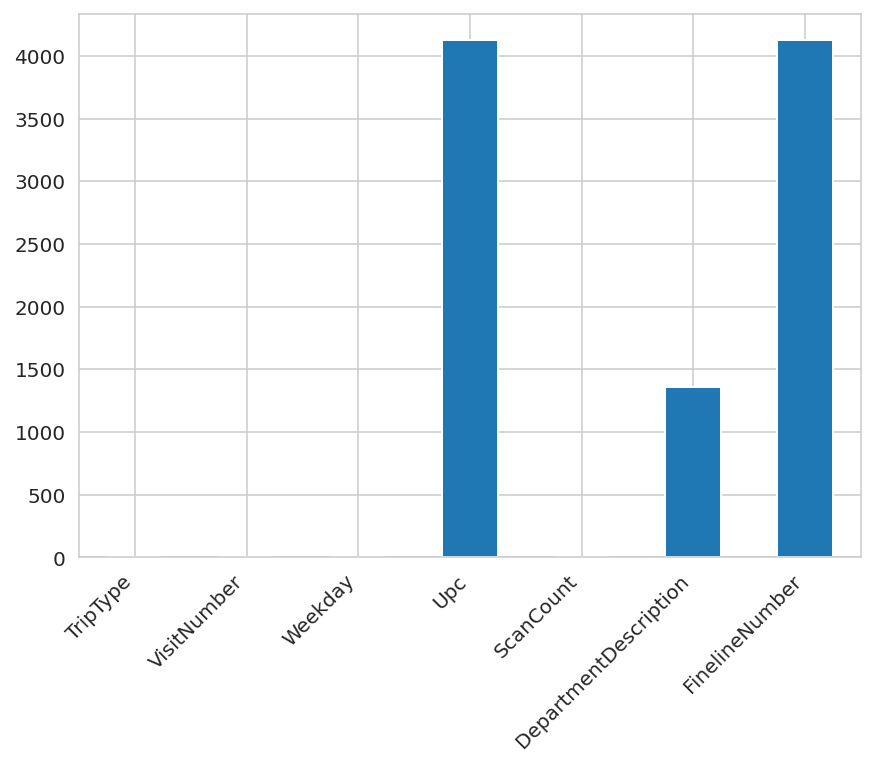

In [51]:
plt.figure(figsize=(7, 5))
train.isnull().sum().plot(kind='bar')
plt.xticks(rotation=45, ha='right')
plt.show()

- Upc, DepartmentDescription, FinelineNumber에 Missing Values 존재
- Upc와 FinelineNumber의 Missing Values는 동시에 나타남
- Missing Value 제거 시 사라지는 VisitNumber 존재
- Feature Engineering에서 VisitNumber에 대한 테이블로 변경
- 최종 모델링 시 Nan은 0으로 처리

### Encode Weekday (Labeling)

In [52]:
wd = {"Monday": 0, "Tuesday": 1, "Wednesday": 2, "Thursday": 3, 
      "Friday": 4, "Saturday": 5, "Sunday": 6}
train["Weekday"] = train["Weekday"].apply(lambda x: wd[x])
test["Weekday"] = test["Weekday"].apply(lambda x: wd[x])

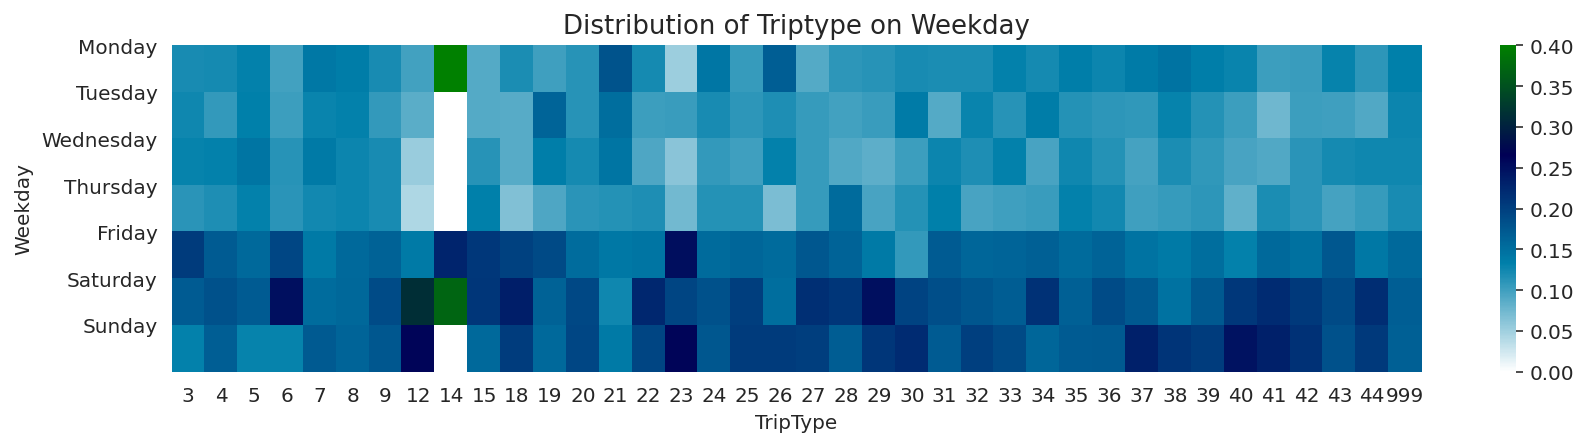

In [53]:
plt.figure(figsize=(14, 3))

sns.heatmap(data=pd.crosstab(train["Weekday"],
                             train["TripType"], 
                             values=train["VisitNumber"],
                             aggfunc='count', 
                             normalize="columns"), cmap="ocean_r")
plt.yticks(range(0,7), list(wd.keys()), rotation="horizontal")
plt.title("Distribution of Triptype on Weekday", fontsize=13)
plt.show()

- TripType 14는 월, 금/토에 많이 나타남
- Feature에 반영 (One-Hot Encoding)

### Uneven Distribution of TripType

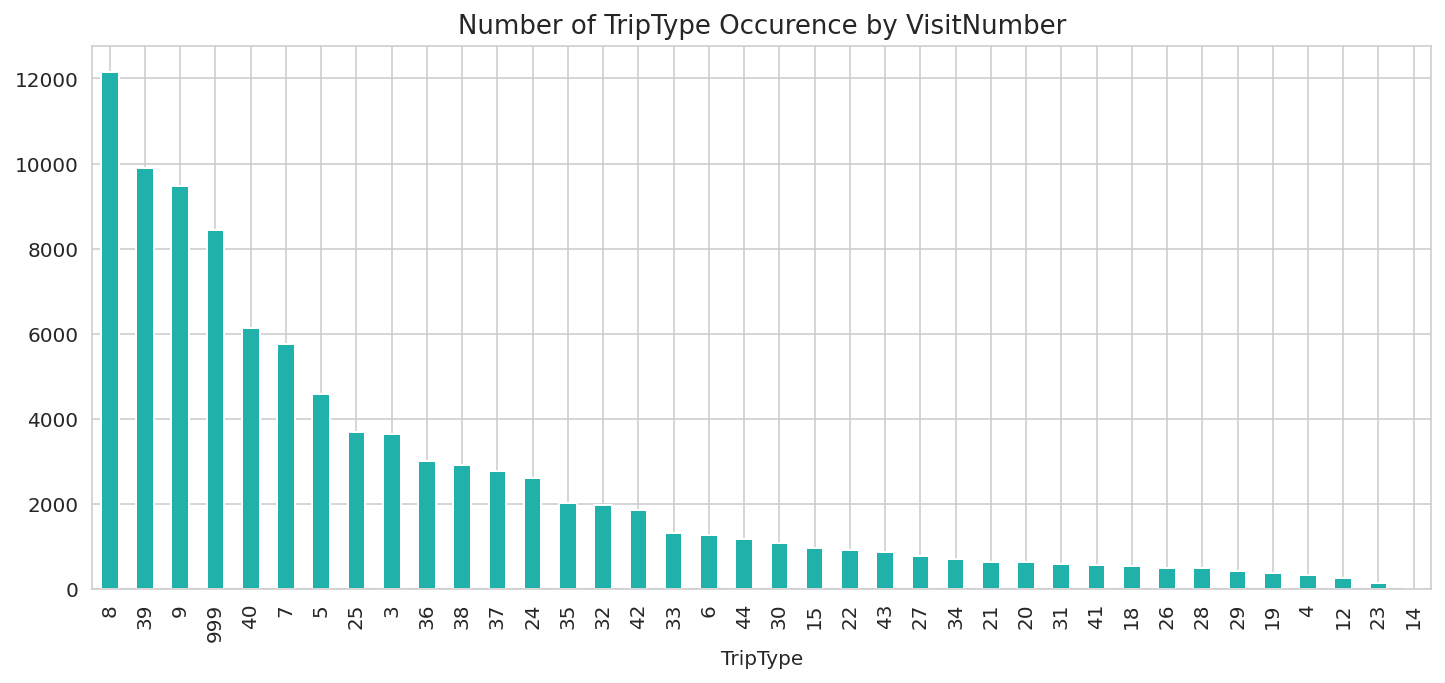

In [54]:
plt.figure(figsize=(12, 5))

sns.set_style('whitegrid')
np.sort(train.TripType.unique())
train_triptypes = train.drop_duplicates("VisitNumber")
a = train_triptypes["TripType"]
a = a.value_counts()
a.plot(kind='bar', color="lightseagreen")
plt.title("Number of TripType Occurence by VisitNumber", fontsize=13)
plt.xlabel("TripType")

plt.show()

### Most Frequent & Least Frequent TripType

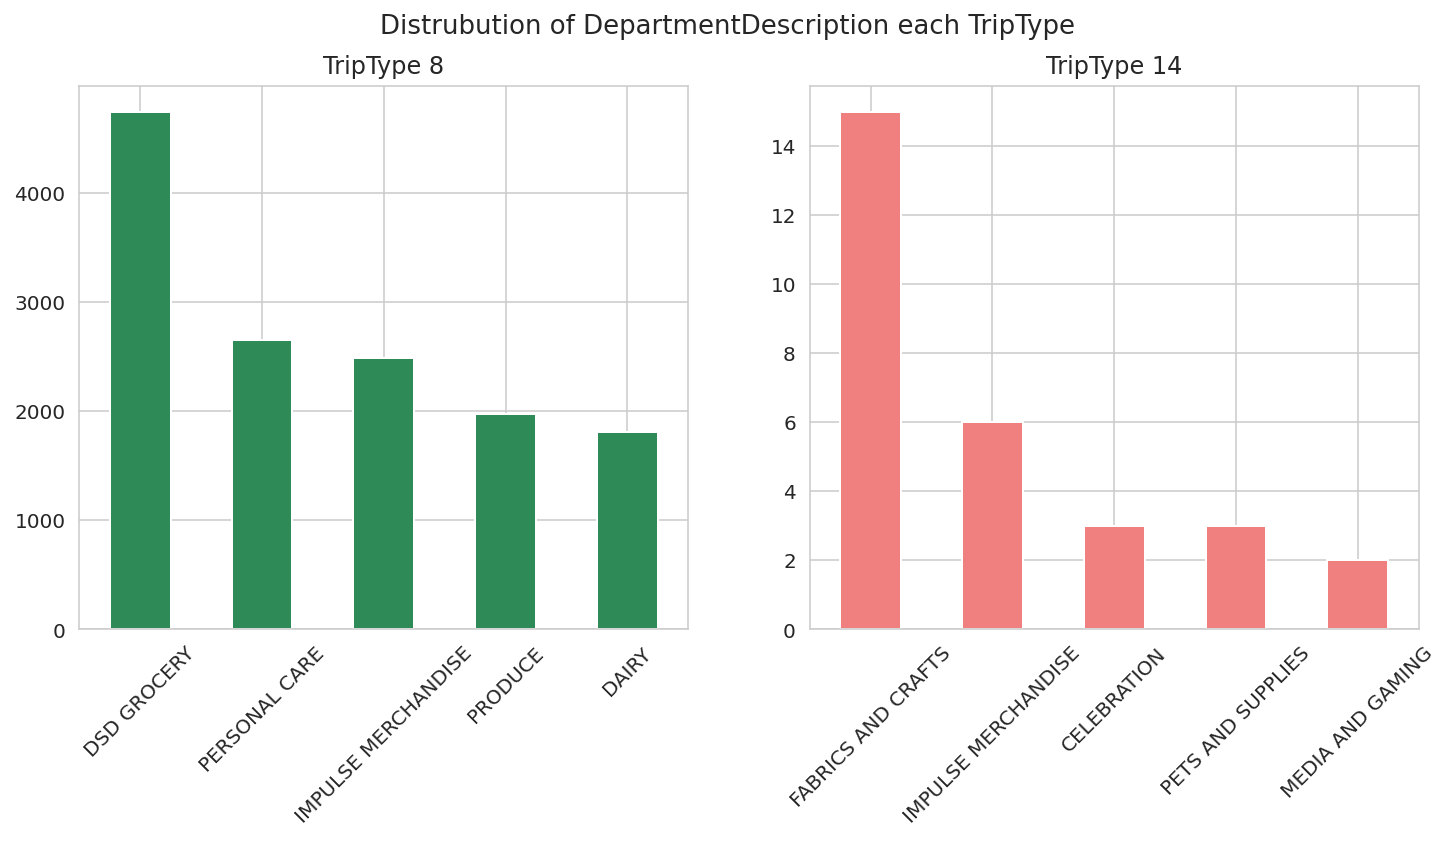

In [56]:
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(121)
type_8 = train[train.TripType == 8]
type_8_items = type_8[["TripType","DepartmentDescription"]]
type_8_items.DepartmentDescription.value_counts().head().plot(kind="bar", rot=45, 
                                        title="TripType 8", color="seagreen")
ax1 = fig.add_subplot(122)
type_14 = train[train.TripType == 14]
type_14_items = type_14[["TripType","DepartmentDescription"]]
type_14_items.DepartmentDescription.value_counts().head().plot(kind="bar", rot=45, 
                                        title="TripType 14", color="lightcoral")

fig.suptitle("Distrubution of DepartmentDescription each TripType", fontsize=13)
plt.xticks(fontsize=10)
plt.show()

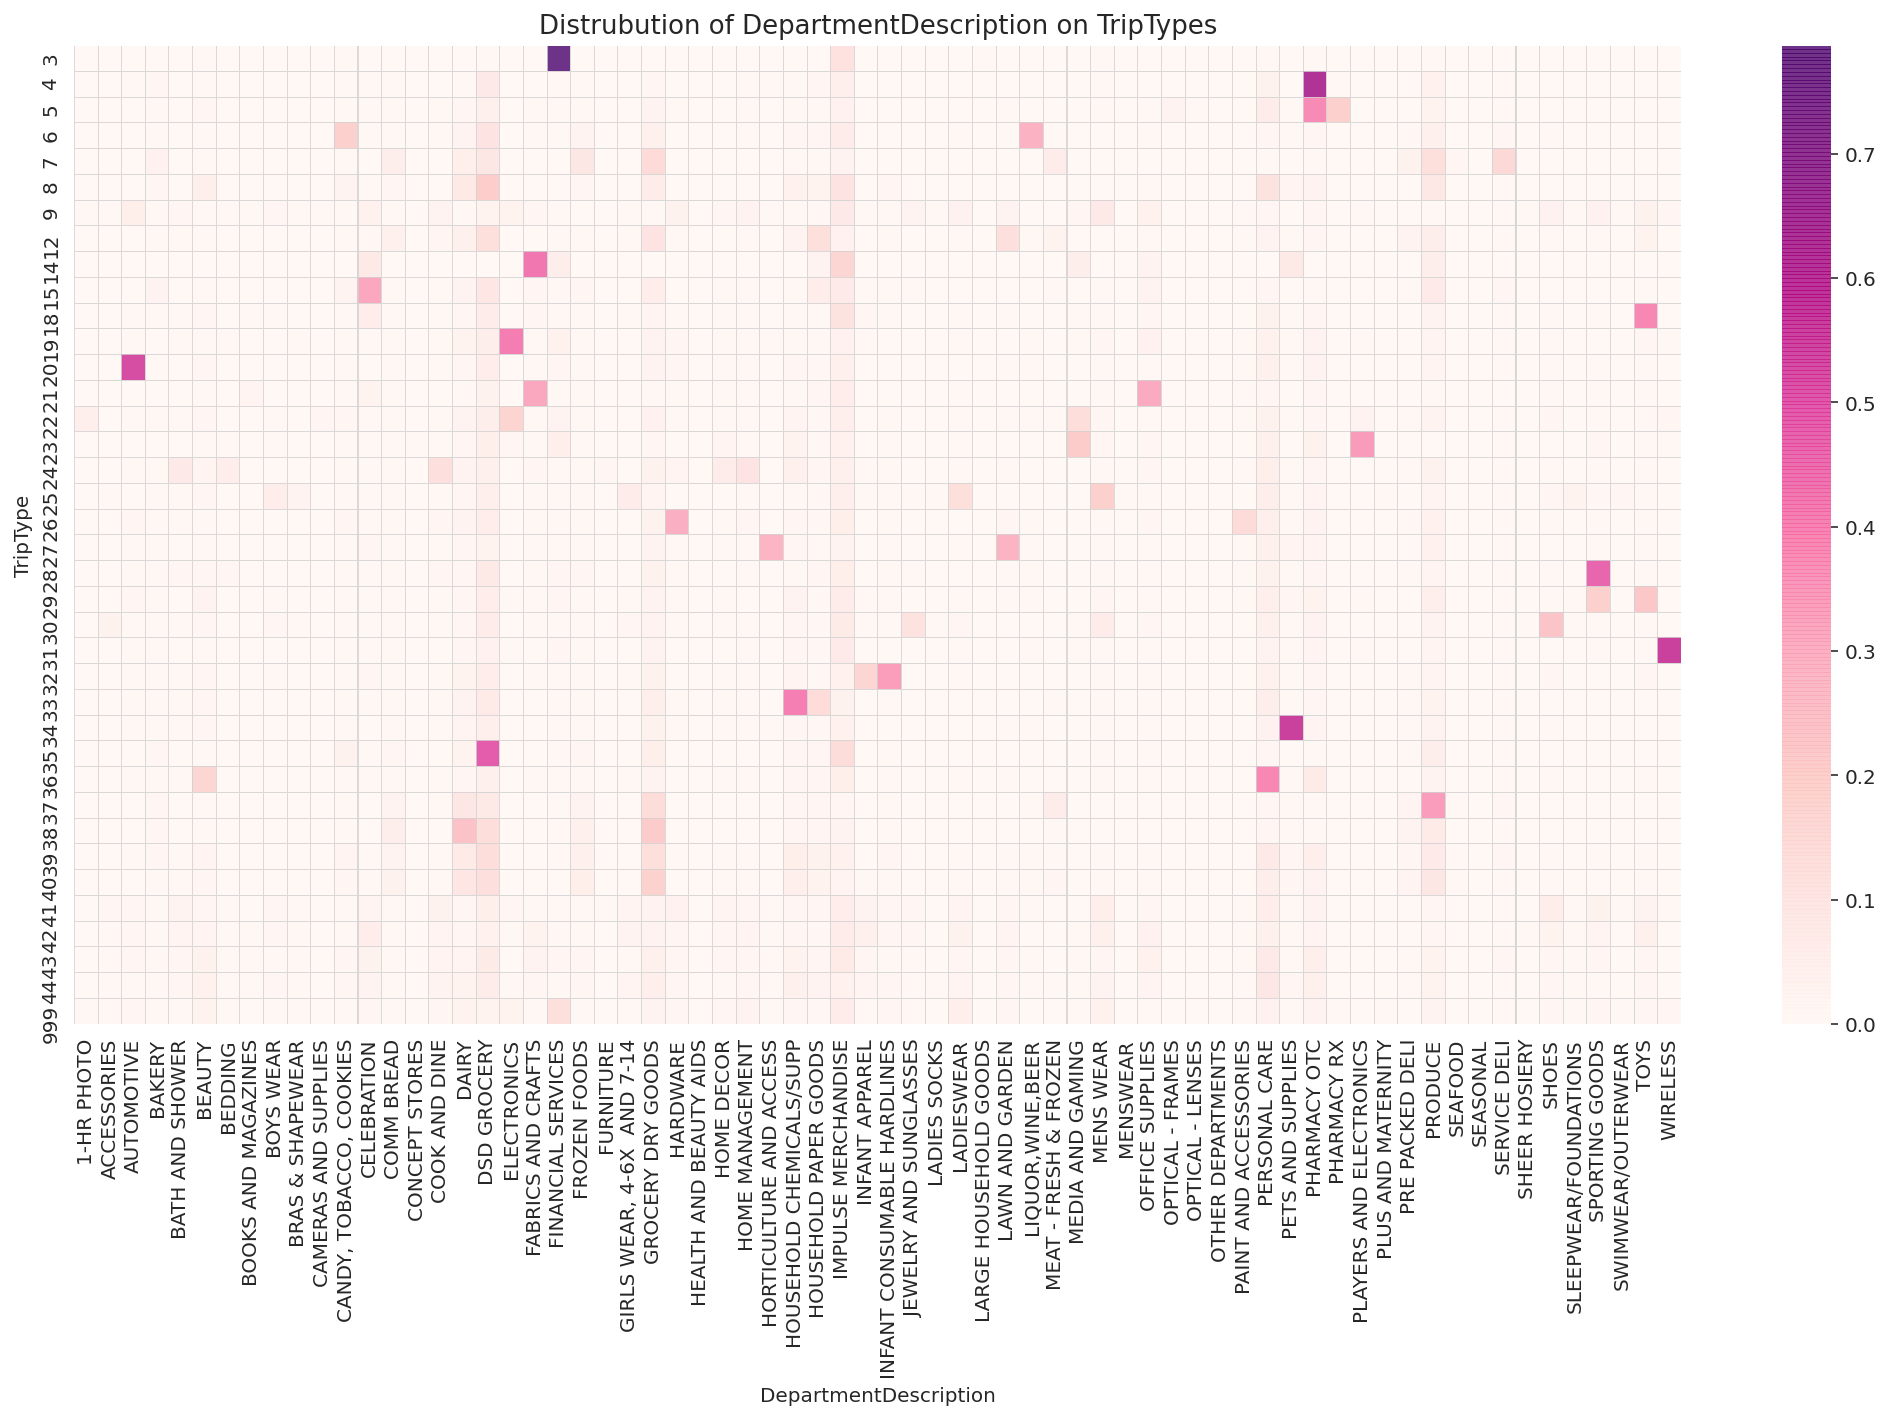

In [57]:
trip_desc = pd.crosstab(train["TripType"], 
                        train["DepartmentDescription"], 
                        values=train["ScanCount"], 
                        aggfunc="count", 
                        normalize="index")

plt.figure(figsize=(18, 9))
sns.heatmap(trip_desc, linecolor="lightgrey", linewidths=0.02, cmap="RdPu", alpha=.8)
plt.title("Distrubution of DepartmentDescription on TripTypes", fontsize=13)
plt.show()

- 비슷한 Department에서 물건 구매시 TripType 분류에 영향을 미치는 것으로 보임
- 하나의 Department에서만 구매한 것이 아닌 여러 Department에서 구매함
- 복수의 Department 방문 여부를 Feature에 반영 (CategoryCounts)

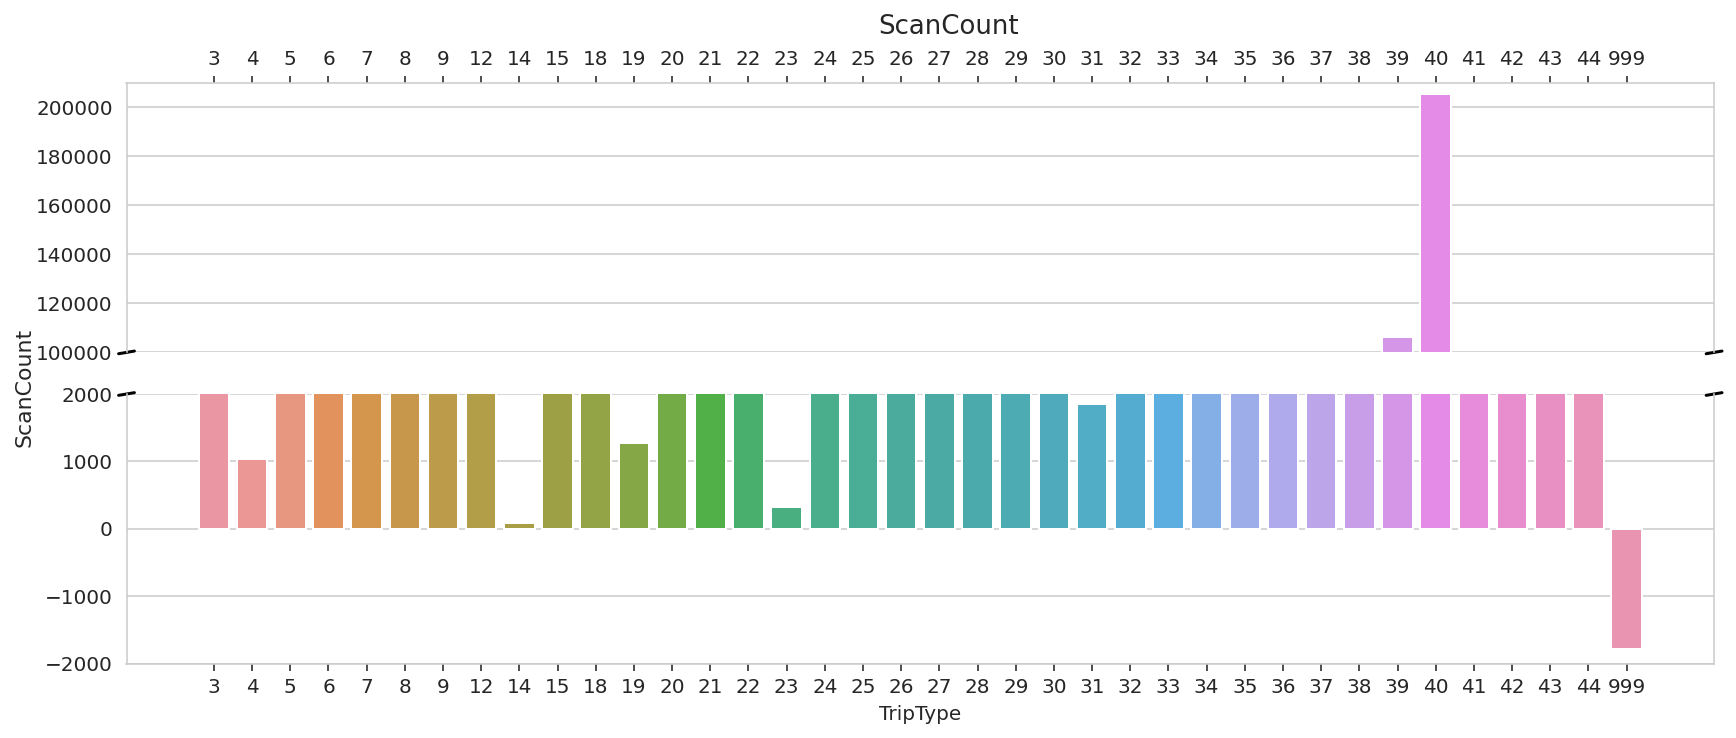

In [58]:
train_plot = train[["TripType", "ScanCount"]]
plot_grouped = train_plot.groupby("TripType", as_index=False).sum()

f, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 5))
sns.barplot(x="TripType", y="ScanCount", data=plot_grouped, ax=ax)
sns.barplot(x="TripType", y="ScanCount", data=plot_grouped, ax=ax2)

ax.set_ylim(100000, 210000)
ax2.set_ylim(-2000, 2000)
ax.xaxis.label.set_visible(False)
ax.yaxis.label.set_visible(False)
ax2.yaxis.label.set_visible(False)

ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop='off') 
ax2.xaxis.tick_bottom()

d = .005

kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  

kwargs.update(transform=ax2.transAxes) 
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs) 

f.text(0, 0.5, 'ScanCount', va='center', rotation='vertical', fontsize=11)
f.text(0.5, 1, 'ScanCount', va='center', rotation='horizontal', fontsize=13)
plt.tight_layout()
plt.show()

- TripType 999는 반품을 위한 방문이라고 생각됨
- Return 여부를 Feature에 반영 (Return)
- ScanCount를 실제 판매수량과 반품으로 나누어서 Feature에 반영 (Pos_Sum, Neg_Sum)

# 2. Feature Engineering

### Decode company code from UPC

In [59]:
def float_to_str(obj):
    """
    Convert Upc code from float to string
    Use this function by applying lambda
    :param obj: "Upc" column of DataFrame
    :return: string converted Upc removing dot.
    """
    while obj != "nan":
        obj = str(obj).split(".")[0]
        return obj

In [60]:
def company(x):
    """
    Return company code from given Upc code.
    :param x: "Upc" column of DataFrame
    :return: company code
    """
    try:
        p = x[:6]
        if p == "000000":
            return x[-5]
        return p
    except:
        return -9999

In [61]:
train["Upc"] = train.Upc.apply(float_to_str)
test["Upc"] = test.Upc.apply(float_to_str)

train["company"] = train.Upc.apply(company) 
test["company"] = test.Upc.apply(company)

### Return Indicator

In [62]:
train.loc[train["ScanCount"] < 0, "Return"] = 1
train.loc[train["Return"] != 1, "Return"] = 0

test.loc[test["ScanCount"] < 0, "Return"] = 1
test.loc[test["Return"] != 1, "Return"] = 0

### Positive ScanCount (The number of sold)

In [63]:
train["Pos_Sum"] = train["ScanCount"]
test["Pos_Sum"] = test["ScanCount"]

train.loc[train["Pos_Sum"] < 0, "Pos_Sum"] = 0
test.loc[test["Pos_Sum"] < 0, "Pos_Sum"] = 0

### Negative ScanCount (The number of returns)

In [64]:
train["Neg_Sum"] = train["ScanCount"]
test["Neg_Sum"] = test["ScanCount"]

train.loc[train["Neg_Sum"] > 0, "Neg_Sum"] = 0
test.loc[test["Neg_Sum"] > 0, "Neg_Sum"] = 0

In [65]:
print(train.shape)
train.tail()

(647054, 11)


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,company,Return,Pos_Sum,Neg_Sum
647049,39,191346,6,32390001778,1,PHARMACY OTC,1118.0,323900,0.0,1,0
647050,39,191346,6,7874205336,1,FROZEN FOODS,1752.0,787420,0.0,1,0
647051,39,191346,6,4072,1,PRODUCE,4170.0,4072,0.0,1,0
647052,8,191347,6,4190007664,1,DAIRY,1512.0,419000,0.0,1,0
647053,8,191347,6,3800059655,1,GROCERY DRY GOODS,3600.0,380005,0.0,1,0


### FinelineNumber most frequently appear

In [66]:
def mode(x):
    counts = Counter(x)
    max_count = max(counts.values())
    ls = [x_i for x_i, count in counts.items() if count == max_count]
    return ls[0]

In [67]:
train_fineline = train[["VisitNumber", "FinelineNumber"]]
train_fineline = train_fineline.groupby("VisitNumber", as_index=False).agg(mode)
train_fineline.rename(columns={"FinelineNumber": "MF_FinelineNumber"}, inplace=True)

test_fineline = test[["VisitNumber", "FinelineNumber"]]
test_fineline = test_fineline.groupby("VisitNumber", as_index=False).agg(mode)
test_fineline.rename(columns={"FinelineNumber": "MF_FinelineNumber"}, inplace=True)

In [68]:
train_fineline.head(5)
test_fineline.head(5)

,VisitNumber,MF_FinelineNumber
0,1,3002.0
1,2,8023.0
2,3,4504.0
3,4,5924.0
4,6,654.0


### The number of UPC and  FinelineNumber for each VisitNumber

In [69]:
train_upc_fine = train[["VisitNumber", "Upc", "FinelineNumber"]]
test_upc_fine = test[["VisitNumber", "Upc", "FinelineNumber"]]

train_upc_fine_group = train_upc_fine.groupby("VisitNumber", as_index=False).count()
train_upc_fine_group.rename(columns={"Upc": "N_Upc", 
                                     "FinelineNumber": "N_FinelineNumber"}, inplace=True)
test_upc_fine_group = test_upc_fine.groupby("VisitNumber", as_index=False).count()
test_upc_fine_group.rename(columns={"Upc": "N_Upc", 
                                    "FinelineNumber": "N_FinelineNumber"}, inplace=True)

In [70]:
train_upc_fine_group.head(5)
test_upc_fine_group.head(5)

,VisitNumber,N_Upc,N_FinelineNumber
0,1,4,4
1,2,4,4
2,3,2,2
3,4,1,1
4,6,2,2


In [71]:
train.drop(["Upc", "FinelineNumber"], axis=1, inplace=True)
test.drop(["Upc", "FinelineNumber"], axis=1, inplace=True)

### One-Hot Encoding of DepartmentDescription

In [72]:
train_dd = pd.get_dummies(train["DepartmentDescription"])
test_dd = pd.get_dummies(test["DepartmentDescription"])

train_dd = pd.concat([train[["VisitNumber"]], train_dd], axis=1)
test_dd = pd.concat([test[["VisitNumber"]], test_dd], axis=1)

train_dd = train_dd.groupby("VisitNumber", as_index=False).sum()
test_dd = test_dd.groupby("VisitNumber", as_index=False).sum()

In [73]:
train_dd.tail()

,VisitNumber,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
95669,191343,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95670,191344,0,0,0,0,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,1
95671,191345,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95672,191346,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95673,191347,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
train_company = train[["VisitNumber", "company"]]
test_company = test[["VisitNumber", "company"]]

train_company = train_company.groupby("VisitNumber", as_index=False).agg(mode)
test_company = test_company.groupby("VisitNumber", as_index=False).agg(mode)

In [75]:
train_company.head(5)
test_company.head(5)

,VisitNumber,company
0,1,725033
1,2,874586
2,3,741081
3,4,728792
4,6,760313


### Pivot data by VisitNumber

In [76]:
train_by_sum = train[["VisitNumber", "ScanCount", "Pos_Sum", "Neg_Sum"]]
test_by_sum = test[["VisitNumber", "ScanCount", "Pos_Sum", "Neg_Sum"]]

train_by_sum = train_by_sum.groupby("VisitNumber", as_index=False).sum()
test_by_sum = test_by_sum.groupby("VisitNumber", as_index=False).sum()

train_by_max = train[["TripType", "VisitNumber", "Weekday", "Return"]]
test_by_max = test[["VisitNumber", "Weekday", "Return"]]

train_by_max = train_by_max.groupby("VisitNumber", as_index=False).max()
test_by_max = test_by_max.groupby("VisitNumber", as_index=False).max()

In [77]:
train = train_by_sum.merge(train_by_max, on=["VisitNumber"])
train = train.merge(train_dd, on=["VisitNumber"])
train = train.merge(train_company, on=["VisitNumber"])
train = train.merge(train_fineline, on=["VisitNumber"])
train = train.merge(train_upc_fine_group, on=["VisitNumber"])

test = test_by_sum.merge(test_by_max, on=["VisitNumber"])
test = test.merge(test_dd, on=["VisitNumber"])
test = test.merge(test_company, on=["VisitNumber"])
test = test.merge(test_fineline, on=["VisitNumber"])
test = test.merge(test_upc_fine_group, on=["VisitNumber"])

In [78]:
train.head(5)
test.head(5)

,VisitNumber,ScanCount,Pos_Sum,Neg_Sum,Weekday,Return,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,...,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS,company,MF_FinelineNumber,N_Upc,N_FinelineNumber
0,1,4,4,0,4,0.0,0,0,0,0,...,1,0,0,0,0,0,725033,3002.0,4,4
1,2,4,4,0,4,0.0,0,0,0,1,...,0,0,0,0,0,0,874586,8023.0,4,4
2,3,0,1,-1,4,1.0,0,0,0,0,...,0,0,0,0,0,0,741081,4504.0,2,2
3,4,1,1,0,4,0.0,0,0,0,0,...,0,0,0,0,0,0,728792,5924.0,1,1
4,6,0,1,-1,4,1.0,0,0,0,0,...,0,0,0,0,0,0,760313,654.0,2,2


- Remove DepartmentDescription not shown in test data
- Segregate features & target

In [79]:
y = train["TripType"]
train = train.drop(["TripType", "HEALTH AND BEAUTY AIDS"], axis=1)

### The counts of DepartmentDescription for each VistNumber

In [80]:
def category_counts(data):
    """
    Count total number of unique DepartmentDescription made on each trip.
    """
    counts = []
    for array in np.asarray(data.loc[:, "1-HR PHOTO":"WIRELESS"]):
        count = 0
        for item in array:
            if item > 0:
                count += 1
        counts.append(count)
    cat_counts = pd.DataFrame(counts)
    cat_counts = cat_counts.rename(columns={0: "CategoryCount"})
    cat_counts = cat_counts.set_index(data.index)

    data.insert(6, "CategoryCounts", cat_counts)

    return data

In [81]:
# from walmart_utils import category_counts
%time train = category_counts(train)
%time test = category_counts(test)

CPU times: user 18.9 s, sys: 22 ms, total: 18.9 s
Wall time: 19.2 s
CPU times: user 18.8 s, sys: 11.1 ms, total: 18.8 s
Wall time: 18.9 s


In [82]:
train.head(5)
test.head(5)

,VisitNumber,ScanCount,Pos_Sum,Neg_Sum,Weekday,Return,CategoryCounts,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,...,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS,company,MF_FinelineNumber,N_Upc,N_FinelineNumber
0,1,4,4,0,4,0.0,3,0,0,0,...,1,0,0,0,0,0,725033,3002.0,4,4
1,2,4,4,0,4,0.0,3,0,0,0,...,0,0,0,0,0,0,874586,8023.0,4,4
2,3,0,1,-1,4,1.0,1,0,0,0,...,0,0,0,0,0,0,741081,4504.0,2,2
3,4,1,1,0,4,0.0,1,0,0,0,...,0,0,0,0,0,0,728792,5924.0,1,1
4,6,0,1,-1,4,1.0,1,0,0,0,...,0,0,0,0,0,0,760313,654.0,2,2


### Ratio of number of UPC and FinelineNumber

In [83]:
train["Upc_FLN"] = train["N_Upc"] / train["N_FinelineNumber"]
test["Upc_FLN"] = test["N_Upc"] / test["N_FinelineNumber"]

In [84]:
train.head(5)
test.head(5)

,VisitNumber,ScanCount,Pos_Sum,Neg_Sum,Weekday,Return,CategoryCounts,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,...,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS,company,MF_FinelineNumber,N_Upc,N_FinelineNumber,Upc_FLN
0,1,4,4,0,4,0.0,3,0,0,0,...,0,0,0,0,0,725033,3002.0,4,4,1.0
1,2,4,4,0,4,0.0,3,0,0,0,...,0,0,0,0,0,874586,8023.0,4,4,1.0
2,3,0,1,-1,4,1.0,1,0,0,0,...,0,0,0,0,0,741081,4504.0,2,2,1.0
3,4,1,1,0,4,0.0,1,0,0,0,...,0,0,0,0,0,728792,5924.0,1,1,1.0
4,6,0,1,-1,4,1.0,1,0,0,0,...,0,0,0,0,0,760313,654.0,2,2,1.0


### One-Hot Encoding of Weekday and Return

In [85]:
train = pd.get_dummies(train, columns=["Weekday", "Return"])
test = pd.get_dummies(test, columns=["Weekday", "Return"])

In [86]:
train.head(5)

,VisitNumber,ScanCount,Pos_Sum,Neg_Sum,CategoryCounts,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,...,Upc_FLN,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6,Return_0.0,Return_1.0
0,1,4,4,0,3,0,0,0,0,0,...,1.0,0,0,0,0,1,0,0,1,0
1,2,4,4,0,3,0,0,0,1,0,...,1.0,0,0,0,0,1,0,0,1,0
2,3,0,1,-1,1,0,0,0,0,0,...,1.0,0,0,0,0,1,0,0,0,1
3,4,1,1,0,1,0,0,0,0,0,...,1.0,0,0,0,0,1,0,0,1,0
4,6,0,1,-1,1,0,0,0,0,0,...,1.0,0,0,0,0,1,0,0,0,1


In [87]:
vn = test[["VisitNumber"]]
train.drop("VisitNumber", axis=1, inplace=True)
test.drop("VisitNumber", axis=1, inplace=True)

In [88]:
train.head(5)

,ScanCount,Pos_Sum,Neg_Sum,CategoryCounts,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,...,Upc_FLN,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6,Return_0.0,Return_1.0
0,4,4,0,3,0,0,0,0,0,0,...,1.0,0,0,0,0,1,0,0,1,0
1,4,4,0,3,0,0,0,1,0,0,...,1.0,0,0,0,0,1,0,0,1,0
2,0,1,-1,1,0,0,0,0,0,0,...,1.0,0,0,0,0,1,0,0,0,1
3,1,1,0,1,0,0,0,0,0,0,...,1.0,0,0,0,0,1,0,0,1,0
4,0,1,-1,1,0,0,0,0,0,0,...,1.0,0,0,0,0,1,0,0,0,1


### Replace Null Value, Inf Value with 0

In [89]:
train.replace(np.inf, 0, inplace=True)
train.fillna(value=0, inplace=True)

test.replace(np.inf, 0, inplace=True)
test.fillna(value=0, inplace=True)

In [90]:
train.head(5)

,ScanCount,Pos_Sum,Neg_Sum,CategoryCounts,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,...,Upc_FLN,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6,Return_0.0,Return_1.0
0,4,4,0,3,0,0,0,0,0,0,...,1.0,0,0,0,0,1,0,0,1,0
1,4,4,0,3,0,0,0,1,0,0,...,1.0,0,0,0,0,1,0,0,1,0
2,0,1,-1,1,0,0,0,0,0,0,...,1.0,0,0,0,0,1,0,0,0,1
3,1,1,0,1,0,0,0,0,0,0,...,1.0,0,0,0,0,1,0,0,1,0
4,0,1,-1,1,0,0,0,0,0,0,...,1.0,0,0,0,0,1,0,0,0,1


### Final Data
- 85 features

### Final Features (Total 85)

- ScanCount
- Return (dummies)
- Pos_Sum
- Neg_Sum
- CategoryCounts
- DepartmentDescription (dummies)
- Company code
- MF_Fineline (Most Frequent FinelineNumbers)
- MF_DepartmentDescription (Most Frequent DepartmentDescription)
- N_UPC (The number of UPC)
- N_FinelineNumber (The number of FinelineNumber)
- UPC_FLN (N_UPC / N_FinelineNumber)
- Weekday (dummies)

# 3. Modeling

- XGBoost

In [91]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [92]:
label_enc = LabelEncoder().fit(y)
y_labeled = label_enc.transform(y)

In [93]:
X_train, X_test, y_train, y_test = train_test_split(
    train, y_labeled, random_state=0)

In [94]:
dtrain = xgb.DMatrix(X_train.values, label=y_train)
dtest = xgb.DMatrix(X_test.values, label=y_test)

In [95]:
num_boost_round = 300
params = {'objective': 'multi:softprob', 
          'eval_metric': 'mlogloss',
          'num_class':38, 
          'max_delta_step': 3, 
          'eta': 0.2}

evals = [(dtrain, 'train'), (dtest, 'eval')]

bst = xgb.train(params=params,  
                dtrain=dtrain, 
                num_boost_round=num_boost_round, 
                evals=evals,
                early_stopping_rounds=10,)

[0]	train-mlogloss:3.07016	eval-mlogloss:3.07893
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 10 rounds.
[1]	train-mlogloss:2.56751	eval-mlogloss:2.58797
[2]	train-mlogloss:2.16511	eval-mlogloss:2.19863
[3]	train-mlogloss:1.87058	eval-mlogloss:1.91257
[4]	train-mlogloss:1.67569	eval-mlogloss:1.72497
[5]	train-mlogloss:1.53132	eval-mlogloss:1.58749
[6]	train-mlogloss:1.41720	eval-mlogloss:1.47881
[7]	train-mlogloss:1.32224	eval-mlogloss:1.38986
[8]	train-mlogloss:1.24536	eval-mlogloss:1.31855
[9]	train-mlogloss:1.17934	eval-mlogloss:1.25734
[10]	train-mlogloss:1.12313	eval-mlogloss:1.20617
[11]	train-mlogloss:1.07469	eval-mlogloss:1.16255
[12]	train-mlogloss:1.03330	eval-mlogloss:1.12567
[13]	train-mlogloss:0.99462	eval-mlogloss:1.09155
[14]	train-mlogloss:0.96220	eval-mlogloss:1.06328
[15]	train-mlogloss:0.93356	eval-mlogloss:1.03831
[16]	train-mlogloss:0.90821	eval-mlogloss:1.01705
[17]	trai

[160]	train-mlogloss:0.38813	eval-mlogloss:0.78344
[161]	train-mlogloss:0.38685	eval-mlogloss:0.78338
[162]	train-mlogloss:0.38549	eval-mlogloss:0.78343
[163]	train-mlogloss:0.38432	eval-mlogloss:0.78362
[164]	train-mlogloss:0.38312	eval-mlogloss:0.78353
[165]	train-mlogloss:0.38194	eval-mlogloss:0.78355
[166]	train-mlogloss:0.38066	eval-mlogloss:0.78361
[167]	train-mlogloss:0.37921	eval-mlogloss:0.78365
Stopping. Best iteration:
[157]	train-mlogloss:0.39209	eval-mlogloss:0.78324



In [96]:
from sklearn.metrics import log_loss
my_test = xgb.DMatrix(X_test.values)
test_predictions = bst.predict(my_test)
print("log loss :", log_loss(y_test, test_predictions).round(5))

log loss : 0.78365


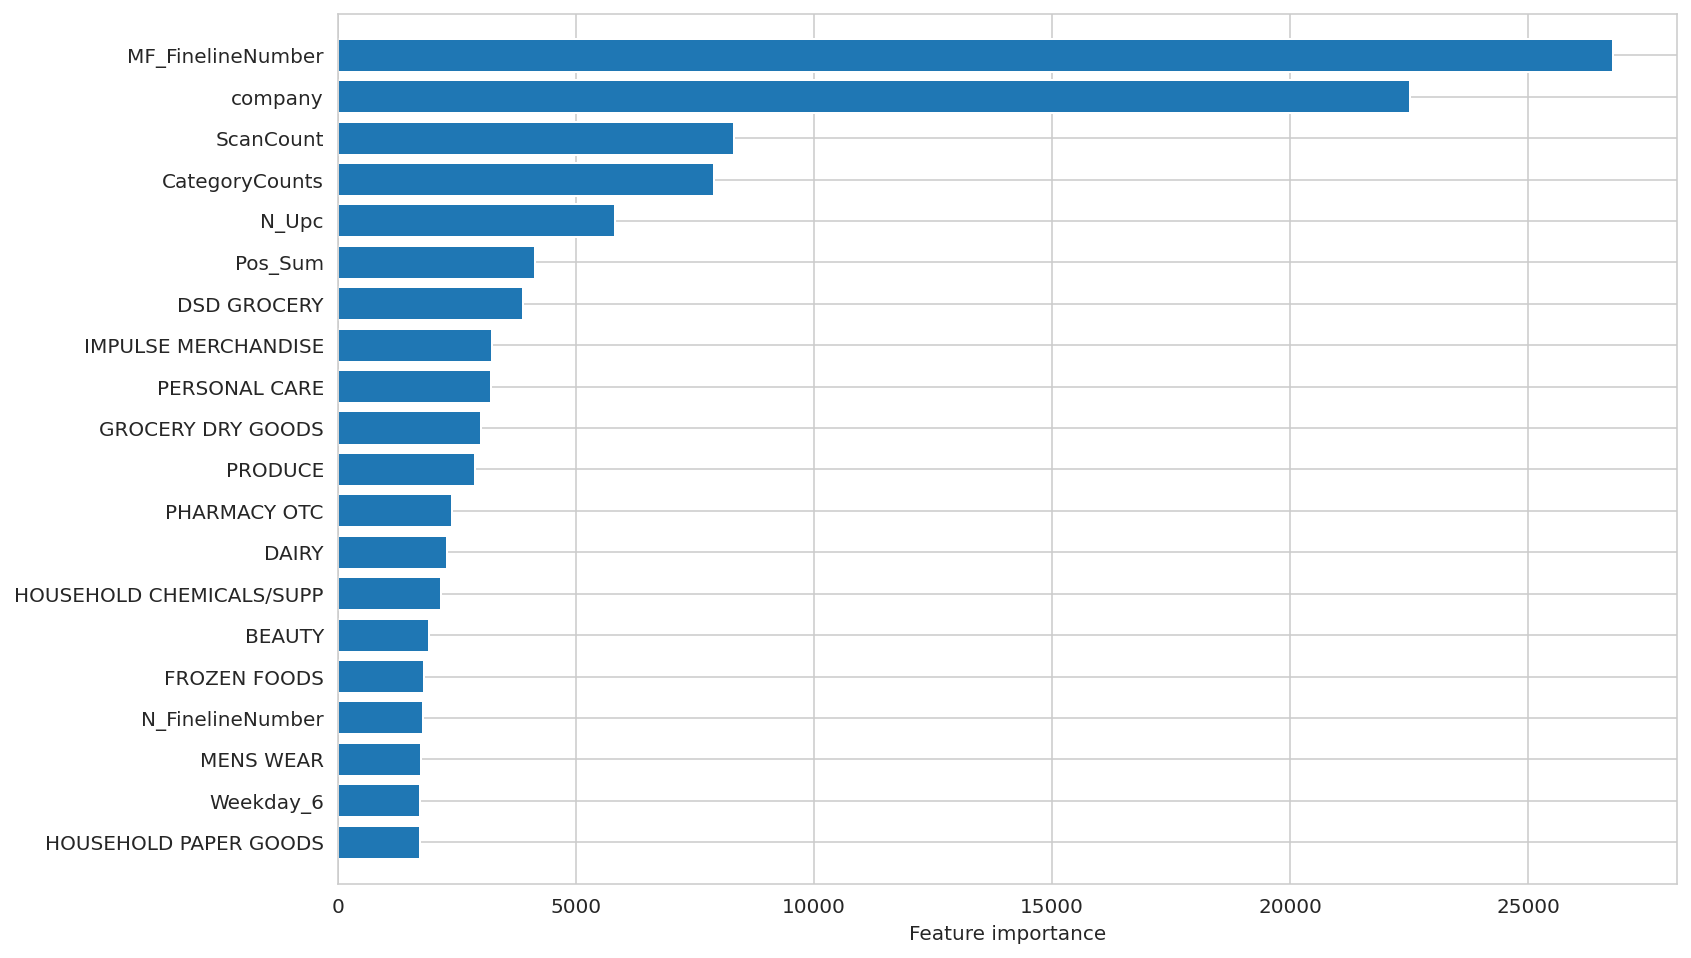

In [97]:
import operator
importance_dict = bst.get_score()
sorted_dict = sorted(importance_dict.items(), key=operator.itemgetter(1))
sorted_dict = sorted_dict[::-1]

indices = []
for i in range(len(sorted_dict)-1):
    indices.append(sorted_dict[i][0])
    
indices = [int(idx[1:]) for idx in indices]

importance_features = []
for idx in indices:
    importance_features.append(train.columns[idx])

importance = list(bst.get_score().values())
importance = sorted(importance)
importance = importance[::-1]

pairs = list(zip(importance, importance_features))
labels = [label[1] for label in pairs]

plt.figure(figsize=(12, 8))
plt.barh(range(20), importance[:20][::-1], align="center")
plt.yticks(np.arange(20), labels[:20][::-1])
plt.xlabel("Feature importance")
plt.ylim(-1, 20)
plt.show()

##### Accuracy score

In [98]:
yprob = test_predictions.reshape(y_test.shape[0], 38)
ylabel = np.argmax(yprob, axis=1)
accuracy = 100 *(1 - (sum(int(ylabel[i]) != y_test[i]
                         for i in range(len(y_test))) / float(len(y_test))))
print("TripType Accuracy = %.2f%%" % accuracy)

TripType Accuracy = 73.73%


### Submission

In [99]:
classes = np.array(list(set(label_enc.inverse_transform(y_labeled))))

dmtest = xgb.DMatrix(test.values) 
pred_proba = bst.predict(dmtest)

proba_df = pd.DataFrame(pred_proba, columns=classes)
proba_df.columns = proba_df.columns.map(lambda x: "TripType_" + str(x))
sub_df = pd.concat([vn, proba_df], axis=1)

sub_df.to_csv("submission.csv", index=False)